In [2]:
!git clone https://github.com/jahnzab/ProjectFlask_internship_Assignment

Cloning into 'ProjectFlask_internship_Assignment'...
remote: Enumerating objects: 2008, done.
remote: Counting objects: 100% (2008/2008), done.
remote: Compressing objects: 100% (1829/1829), done.
remote: Total 2008 (delta 207), reused 1925 (delta 160), pack-reused 0 (from 0)
Receiving objects: 100% (2008/2008), 6.31 MiB | 10.30 MiB/s, done.
Resolving deltas: 100% (207/207), done.


In [3]:
%cd /content/ProjectFlask_internship_Assignment/


/content/ProjectFlask_internship_Assignment


In [4]:
from google.colab import files
files.upload()  # select your kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jahanzaieb","key":"bbb4e443e35fe90e1755247d4c45cc08"}'}

In [5]:
!pip install kaggle
# Upload kaggle.json via file upload widget or copy it to ~/.kaggle/kaggle.json
!mkdir -p ~/.kaggle
!cp /content/ProjectFlask_internship_Assignment/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d shubhamgoel27/dermnet -p ./dermatology_dataset
!unzip ./dermatology_dataset/dermnet.zip -d ./dermatology_dataset


Streaming output truncated to the last 5000 lines.
  inflating: ./dermatology_dataset/train/Seborrheic Keratoses and other Benign Tumors/keloids-8.jpg  
  inflating: ./dermatology_dataset/train/Seborrheic Keratoses and other Benign Tumors/keloids-80.jpg  
  inflating: ./dermatology_dataset/train/Seborrheic Keratoses and other Benign Tumors/keloids-9.jpg  
  inflating: ./dermatology_dataset/train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-100.jpg  
  inflating: ./dermatology_dataset/train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-101.jpg  
  inflating: ./dermatology_dataset/train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-102.jpg  
  inflating: ./dermatology_dataset/train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-103.jpg  
  inflating: ./dermatology_dataset/train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-104.jpg  
  inflating: ./dermatology_dataset/train/Seborrheic Keratoses and other Benign Tum

In [ ]:
# Make a folder for text dataset
!mkdir -p ./mental_health_dataset

# Download the Kaggle dataset
!kaggle datasets download -d ayushcl/mhp-anxiety-stress-depression-dataset -p ./mental_health_dataset

# Unzip it
!unzip ./mental_health_dataset/mhp-anxiety-stress-depression-dataset.zip -d ./mental_health_dataset


In [6]:
!python /content/ProjectFlask_internship_Assignment/train_image.py



Using device: cuda:0
Total Classes:  23
Total train images:  15557
Total test images:  4002
                                                Class  Train  Test
0                             Acne and Rosacea Photos    840   312
1   Actinic Keratosis Basal Cell Carcinoma and oth...   1149   288
2                            Atopic Dermatitis Photos    489   123
3                              Bullous Disease Photos    448   113
4   Cellulitis Impetigo and other Bacterial Infect...    288    73
5                                       Eczema Photos   1235   309
6                        Exanthems and Drug Eruptions    404   101
7   Hair Loss Photos Alopecia and other Hair Diseases    239    60
8                    Herpes HPV and other STDs Photos    405   102
9        Light Diseases and Disorders of Pigmentation    568   143
10         Lupus and other Connective Tissue diseases    420   105
11                Melanoma Skin Cancer Nevi and Moles    463   116
12                 Nail Fungus and ot

In [12]:
!pip install pandas numpy scikit-learn imbalanced-learn

Classification Report:
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.81      0.84      0.82       312
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.70      0.62      0.66       288
                                          Atopic Dermatitis Photos       0.54      0.64      0.59       123
                                            Bullous Disease Photos       0.53      0.58      0.55       113
                Cellulitis Impetigo and other Bacterial Infections       0.43      0.49      0.46        73
                                                     Eczema Photos       0.67      0.60      0.63       309
                                      Exanthems and Drug Eruptions       0.36      0.64      0.46       101
                 Hair Loss Photos Alopecia and other Hair Diseases       0.55      0.82      0.66        60
    

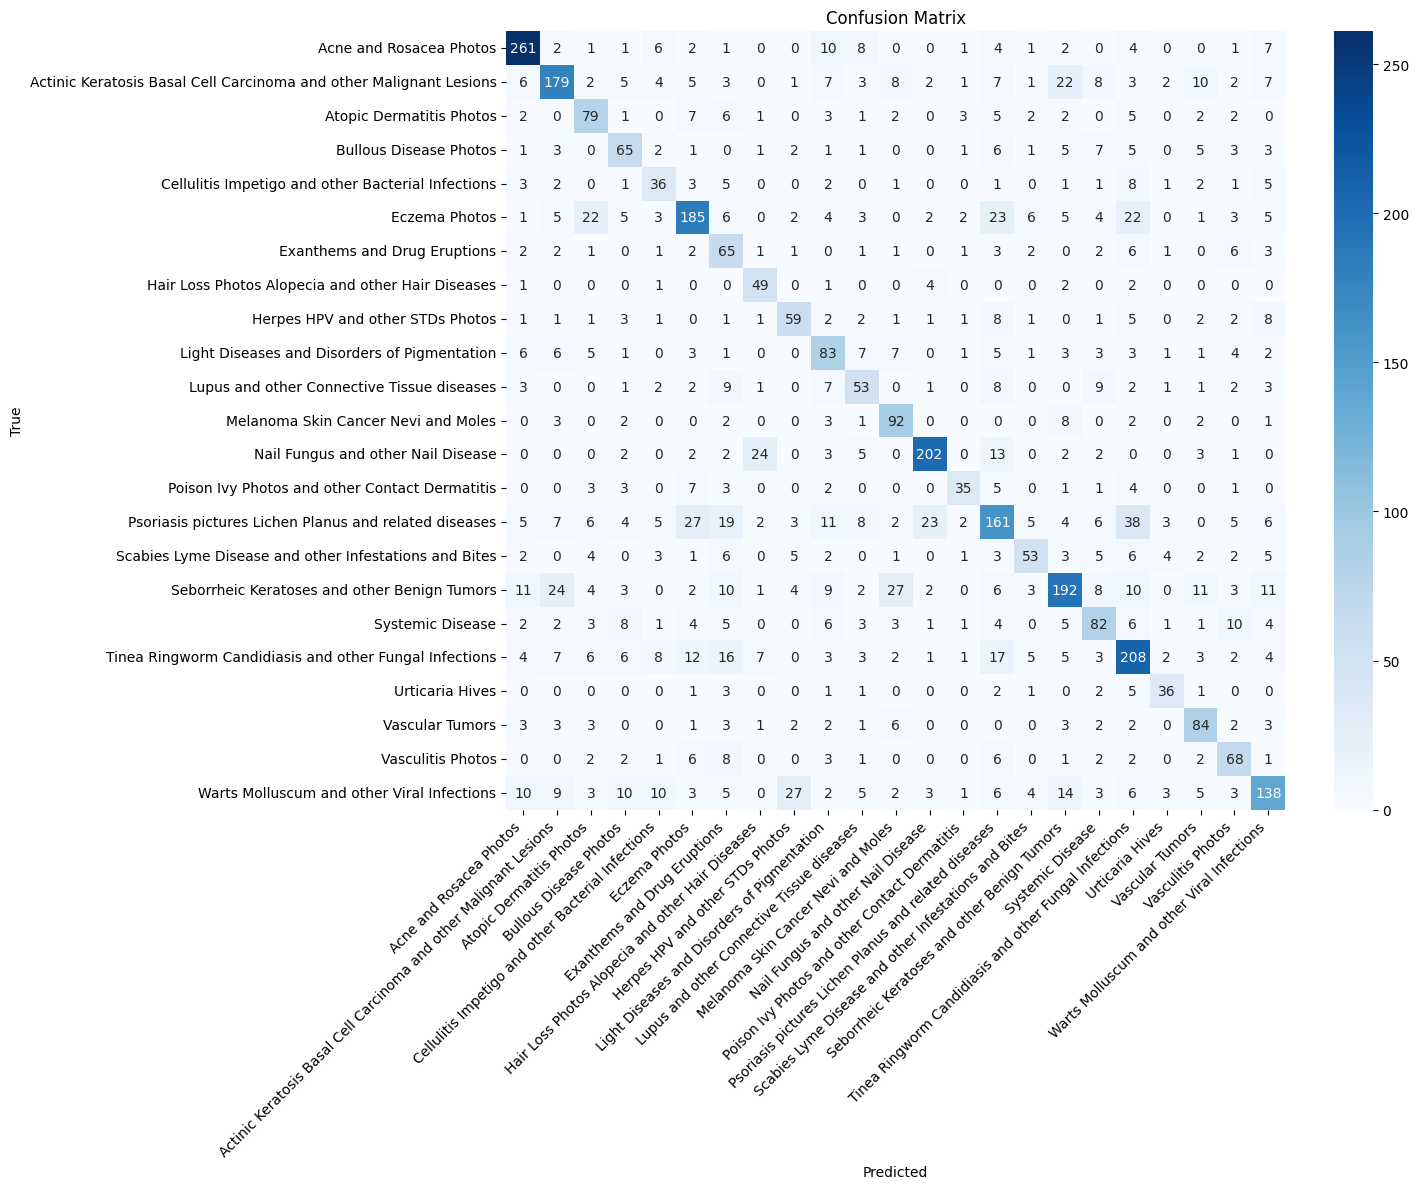

In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Define device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load EfficientNetV2-S model
def load_model(model_path, num_classes=23):
    model = models.efficientnet_v2_s(weights=None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    model = model.to(device)

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)  # Try loading directly if no model_state_dict
    model.eval()
    return model

# Evaluation function with confusion matrix
def evaluate_model(model, test_loader, class_names):
    model.to(device)
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Main function
def main():
    # Class names from the provided output
    class_names = [
        "Acne and Rosacea Photos",
        "Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions",
        "Atopic Dermatitis Photos",
        "Bullous Disease Photos",
        "Cellulitis Impetigo and other Bacterial Infections",
        "Eczema Photos",
        "Exanthems and Drug Eruptions",
        "Hair Loss Photos Alopecia and other Hair Diseases",
        "Herpes HPV and other STDs Photos",
        "Light Diseases and Disorders of Pigmentation",
        "Lupus and other Connective Tissue diseases",
        "Melanoma Skin Cancer Nevi and Moles",
        "Nail Fungus and other Nail Disease",
        "Poison Ivy Photos and other Contact Dermatitis",
        "Psoriasis pictures Lichen Planus and related diseases",
        "Scabies Lyme Disease and other Infestations and Bites",
        "Seborrheic Keratoses and other Benign Tumors",
        "Systemic Disease",
        "Tinea Ringworm Candidiasis and other Fungal Infections",
        "Urticaria Hives",
        "Vascular Tumors",
        "Vasculitis Photos",
        "Warts Molluscum and other Viral Infections"
    ]

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load test dataset (adjust path to your test dataset)
    test_dataset_path = '/content/ProjectFlask_internship_Assignment/dermatology_dataset/test'  # Replace with actual path
    test_dataset = ImageFolder(test_dataset_path, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Load model
    model_path = '/content/ProjectFlask_internship_Assignment/best_derma_model_efficientnetv2s.pth'
    model = load_model(model_path, num_classes=23)

    # Evaluate model
    evaluate_model(model, test_loader, class_names)

if __name__ == "__main__":
    main()

In [8]:
# Make a folder for text dataset
!mkdir -p ./mental_health_dataset

# Download the Kaggle dataset
!kaggle datasets download -d ayushcl/mhp-anxiety-stress-depression-dataset -p ./mental_health_dataset

# Unzip it
!unzip ./mental_health_dataset/mhp-anxiety-stress-depression-dataset.zip -d ./mental_health_dataset


Dataset URL: https://www.kaggle.com/datasets/ayushcl/mhp-anxiety-stress-depression-dataset
License(s): apache-2.0
  0% 0.00/75.3k [00:00<?, ?B/s]
100% 75.3k/75.3k [00:00<00:00, 279MB/s]
Archive:  ./mental_health_dataset/mhp-anxiety-stress-depression-dataset.zip
  inflating: ./mental_health_dataset/Anxiety.csv  
  inflating: ./mental_health_dataset/Depression.csv  
  inflating: ./mental_health_dataset/Stress.csv  
